# BASIC TRAINING END2END

### Faster RCNN

In [1]:
import _init_paths
from fast_rcnn.train import get_training_roidb, train_net
from fast_rcnn.test import test_net, im_detect
from fast_rcnn.config import cfg, cfg_from_file, cfg_from_list, get_output_dir
from fast_rcnn.bbox_transform import clip_boxes, bbox_transform_inv
from datasets.factory import get_imdb
from rpn.generate import imdb_proposals
import roi_data_layer.roidb as rdl_roidb

### Caffe

In [2]:
import caffe
from caffe.proto import caffe_pb2
import google.protobuf as pb2

### Utils

In [3]:
## import argparse
import pprint
import numpy as np
import sys, os
import multiprocessing as mp
import cPickle
import shutil
from utils.timer import Timer

### Plotting

In [4]:
from IPython.display import Image
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

## Paths

In [5]:
!cat /home/jogue/workspace/jg_pfr/models/pascal_voc/VGG16/faster_rcnn_end2end/test.prototxt


name: "VGG_ILSVRC_16_layers"

input: "data"
input_shape {
  dim: 1
  dim: 3
  dim: 224
  dim: 224
}

input: "im_info"
input_shape {
  dim: 1
  dim: 3
}

layer {
  name: "conv1_1"
  type: "Convolution"
  bottom: "data"
  top: "conv1_1"
  param {
    lr_mult: 0
    decay_mult: 0
  }
  param {
    lr_mult: 0
    decay_mult: 0
  }
  convolution_param {
    num_output: 64
    pad: 1
    kernel_size: 3
  }
}
layer {
  name: "relu1_1"
  type: "ReLU"
  bottom: "conv1_1"
  top: "conv1_1"
}
layer {
  name: "conv1_2"
  type: "Convolution"
  bottom: "conv1_1"
  top: "conv1_2"
  param {
    lr_mult: 0
    decay_mult: 0
  }
  param {
    lr_mult: 0
    decay_mult: 0
  }
  convolution_param {
    num_output: 64
    pad: 1
    kernel_size: 3
  }
}
layer {
  name: "relu1_2"
  type: "ReLU"
  bottom: "conv1_2"
  top: "conv1_2"
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1_2"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "conv2_1"
  ty

In [6]:
#########################################################################################################
#########################################################################################################
#########################################################################################################

#PASCAL
#pretrained_model = '/home/jogue/workspace/jg_pfr/data/faster_rcnn_models/VGG16_faster_rcnn_final.caffemodel'
#solver_prototxt = '/home/jogue/workspace/jg_pfr/models/pascal_voc/VGG16/faster_rcnn_end2end/solver.prototxt'
#test_prototxt = '/home/jogue/workspace/jg_pfr/models/pascal_voc/VGG16/faster_rcnn_end2end/test.prototxt'

#NYUDV2
pretrained_model = '/home/jogue/workspace/jg_pfr/data/faster_rcnn_models/VGG16_faster_rcnn_final.caffemodel'
solver_prototxt = '/home/jogue/workspace/jg_pfr/models/nyudv2gup/VGG16/faster_rcnn_end2end/solver.prototxt'
test_prototxt = '/home/jogue/workspace/jg_pfr/models/nyudv2gup/VGG16/faster_rcnn_end2end/test.prototxt'
#pretrained_model = '/home/jogue/workspace/caffemodels/nyud-fcn32s-color-heavy.caffemodel'
#solver_prototxt = '/home/jogue/workspace/jg_pfr/models/nyud_v2_40gupta/VGG16_from_FCN/faster_rcnn_end2end/solver_fcn.prototxt'

#########################################################################################################
#########################################################################################################
#########################################################################################################

#PASCAL
#path_proposal = '/home/jogue/workspace/jg_pfr/output/2017janvier23/'
#output_dir = '/home/jogue/workspace/jg_pfr/output/2017janvier23/'

#NYUDV2
path_proposal = '/home/jogue/workspace/jg_pfr/output/2017janvier22/'
output_dir = '/home/jogue/workspace/jg_pfr/output/nyudv2gup/'

#########################################################################################################
#########################################################################################################
#########################################################################################################

# PASCAL
#imdb_train_name = 'voc_2007_trainval'
#imdb_test_name = 'voc_2007_fake'
#imdb_test_name = 'voc_2007_test'
# NYUDV2
imdb_train_name = 'nyud_v2_trainGupta_rgb_i_100_8bits'
imdb_test_name = 'nyud_v2_valGupta_rgb_i_100_8bits'

#########################################################################################################
#########################################################################################################
#########################################################################################################
#PASCAL
#cfg_from_file('/home/jogue/workspace/jg_pfr/experiments/cfgs/faster_rcnn_end2end.yml')

#NYUDV2
cfg_from_file('/home/jogue/workspace/jg_pfr/experiments/cfgs/faster_rcnn_end2end.yml')

#########################################################################################################
#########################################################################################################
#########################################################################################################

cfg.GPU_ID = 0
cfg.TRAIN.SNAPSHOT_ITERS = 795
cfg.TRAIN.SNAPSHOT_INFIX = 'jg'
cfg.TEST.PROPOSAL_METHOD = 'rpn'
#########################################################################################################
#########################################################################################################
#########################################################################################################
#print 'Init model: {}'.format(path_net_weights)
#print 'RPN proposals: {}'.format(path_proposal)
#print('Using config:')
pprint.pprint(cfg)

{'DATA_DIR': '/home/jogue/workspace/jg_pfr/data',
 'DEDUP_BOXES': 0.0625,
 'EPS': 1e-14,
 'EXP_DIR': 'faster_rcnn_end2end',
 'GPU_ID': 0,
 'MATLAB': 'matlab',
 'MODELS_DIR': '/home/jogue/workspace/jg_pfr/models/pascal_voc',
 'PIXEL_MEANS': array([[[ 102.9801,  115.9465,  122.7717]]]),
 'RNG_SEED': 3,
 'ROOT_DIR': '/home/jogue/workspace/jg_pfr',
 'TEST': {'BBOX_REG': True,
          'HAS_RPN': True,
          'MAX_SIZE': 1000,
          'NMS': 0.3,
          'PROPOSAL_METHOD': 'rpn',
          'RPN_MIN_SIZE': 16,
          'RPN_NMS_THRESH': 0.7,
          'RPN_POST_NMS_TOP_N': 300,
          'RPN_PRE_NMS_TOP_N': 6000,
          'SCALES': [600],
          'SVM': False},
 'TRAIN': {'ASPECT_GROUPING': True,
           'BATCH_SIZE': 256,
           'BBOX_INSIDE_WEIGHTS': [1.0, 1.0, 1.0, 1.0],
           'BBOX_NORMALIZE_MEANS': [0.0, 0.0, 0.0, 0.0],
           'BBOX_NORMALIZE_STDS': [0.1, 0.1, 0.2, 0.2],
           'BBOX_NORMALIZE_TARGETS': True,
           'BBOX_NORMALIZE_TARGETS_PRECOMPUTE

## Init caffe

In [7]:
## np.random.seed(cfg.RNG_SEED)
caffe.set_random_seed(cfg.RNG_SEED)
# set up caffe
caffe.set_mode_gpu()
caffe.set_device(cfg.GPU_ID)

## Get imdb

### train

In [8]:
imdb_train = get_imdb(imdb_train_name)
imdb_train.set_proposal_method(cfg.TRAIN.PROPOSAL_METHOD)
if cfg.TRAIN.USE_FLIPPED:
    print 'Appending horizontally-flipped training examples...'
    imdb_train.append_flipped_images()
    print 'done'
    print ''
    
print 'Enriching the imdb\'s roidb...'
rdl_roidb.prepare_roidb(imdb_train)
print 'done'
print ''

roidb_train = imdb_train.roidb
if cfg.TRAIN.BBOX_REG:
    print 'Computing bounding-box regression targets...'
    bbox_means, bbox_stds = rdl_roidb.add_bbox_regression_targets(roidb_train)
    print 'done'
    print ''

self.num_classes = 41
Appending horizontally-flipped training examples...
nyud_v2_trainGupta_rgb_i_100_8bits gt roidb loaded from /home/jogue/workspace/jg_pfr/data/cache/nyud_v2_trainGupta_rgb_i_100_8bits_gt_roidb.pkl
done

Enriching the imdb's roidb...
done

Computing bounding-box regression targets...
num class in add_bbox_regression_targets : 41
Normalizing targets
done



## Loading solver and pretrained_model

In [9]:
solver = caffe.SGDSolver(solver_prototxt)
if pretrained_model is not None:
    print ('Loading pretrained model '
           'weights from {:s}').format(pretrained_model)
    solver.net.copy_from(pretrained_model)
    print 'done'
    print ''

solver_param = caffe_pb2.SolverParameter()
with open(solver_prototxt, 'rt') as f:
    pb2.text_format.Merge(f.read(), solver_param)    

RoiDataLayer: name_to_top: {'gt_boxes': 2, 'data': 0, 'im_info': 1}
Loading pretrained model weights from /home/jogue/workspace/jg_pfr/data/faster_rcnn_models/VGG16_faster_rcnn_final.caffemodel
done



In [10]:
a = [(k, v.data.shape) for k, v in solver.net.blobs.items()]
a

[('data', (1, 3, 600, 1000)),
 ('im_info', (1, 3)),
 ('gt_boxes', (1, 4)),
 ('data_input-data_0_split_0', (1, 3, 600, 1000)),
 ('data_input-data_0_split_1', (1, 3, 600, 1000)),
 ('im_info_input-data_1_split_0', (1, 3)),
 ('im_info_input-data_1_split_1', (1, 3)),
 ('gt_boxes_input-data_2_split_0', (1, 4)),
 ('gt_boxes_input-data_2_split_1', (1, 4)),
 ('conv1_1', (1, 64, 600, 1000)),
 ('conv1_2', (1, 64, 600, 1000)),
 ('pool1', (1, 64, 300, 500)),
 ('conv2_1', (1, 128, 300, 500)),
 ('conv2_2', (1, 128, 300, 500)),
 ('pool2', (1, 128, 150, 250)),
 ('conv3_1', (1, 256, 150, 250)),
 ('conv3_2', (1, 256, 150, 250)),
 ('conv3_3', (1, 256, 150, 250)),
 ('pool3', (1, 256, 75, 125)),
 ('conv4_1', (1, 512, 75, 125)),
 ('conv4_2', (1, 512, 75, 125)),
 ('conv4_3', (1, 512, 75, 125)),
 ('pool4', (1, 512, 38, 63)),
 ('conv5_1', (1, 512, 38, 63)),
 ('conv5_2', (1, 512, 38, 63)),
 ('conv5_3', (1, 512, 38, 63)),
 ('conv5_3_relu5_3_0_split_0', (1, 512, 38, 63)),
 ('conv5_3_relu5_3_0_split_1', (1, 512, 38

## Init input layer with roiDB

In [11]:
solver.net.layers[0].set_roidb(roidb_train)

## Training

In [12]:
def snapshot(bbox_stds,bbox_means):
        """Take a snapshot of the network after unnormalizing the learned
        bounding-box regression weights. This enables easy use at test-time.
        """
        print "Snapshotting..."
        scale_bbox_params = (cfg.TRAIN.BBOX_REG and
                             cfg.TRAIN.BBOX_NORMALIZE_TARGETS and
                             solver.net.params.has_key('bbox_pred'))

        if scale_bbox_params:
            #print 'Scaling before saving'
            # save original values
            orig_0 = solver.net.params['bbox_pred'][0].data.copy()
            orig_1 = solver.net.params['bbox_pred'][1].data.copy()

            # scale and shift with bbox reg unnormalization; then save snapshot
            solver.net.params['bbox_pred'][0].data[...] = (solver.net.params['bbox_pred'][0].data * bbox_stds[:, np.newaxis])
            solver.net.params['bbox_pred'][1].data[...] = (solver.net.params['bbox_pred'][1].data * bbox_stds + bbox_means)

        #infix = ('_' + cfg.TRAIN.SNAPSHOT_INFIX if cfg.TRAIN.SNAPSHOT_INFIX != '' else '')
        #filename = (solver_param.snapshot_prefix + infix + '_iter_{:d}'.format(solver.iter))
        #filename = os.path.join(output_dir, filename)
        #solver.net.save(str(filename + '.caffemodel'))
        #print 'Wrote snapshot to: {:s}'.format(filename)
        
        solver.snapshot()
        

        if scale_bbox_params:
            #print 'Unscaling before resuming'
            # restore net to original state
            solver.net.params['bbox_pred'][0].data[...] = orig_0
            solver.net.params['bbox_pred'][1].data[...] = orig_1
        print "done."
        return solver_param.snapshot_prefix+"_iter_"+str(solver.iter)

In [13]:
timer = Timer()
list_iters = []
list_loss_bbox = []
list_loss_cls = []
list_rpn_cls_loss = []
list_rpn_loss_bbox = []
#custom_test_interval = 1590
#custom_test_interval = 795
custom_test_interval = 1
test_dataset_size = 654
custom_display_interval = 5
#max_iters = 159000
max_iters = 1000

custom_debug = False


last_snapshot_iter = -1
timer = Timer()
model_paths = []

## Training loop

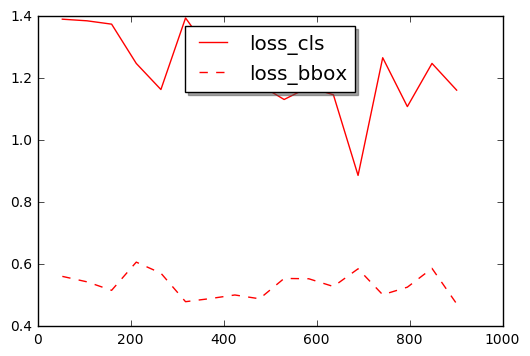

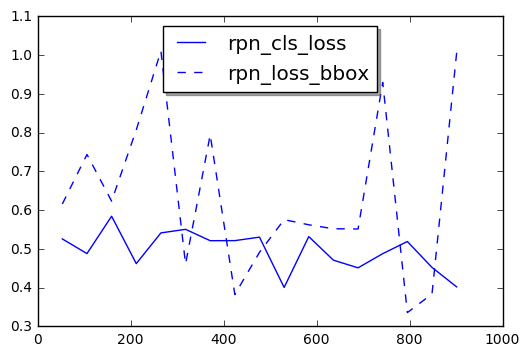

KeyboardInterrupt: 

In [14]:
while solver.iter < max_iters:
    if custom_debug:
        print solver.iter
    solver.step(53)

    list_iters.append(solver.iter)
    list_loss_bbox.append(float(solver.net.blobs['loss_bbox'].data[...]))
    list_loss_cls.append(float(solver.net.blobs['loss_cls'].data[...]))
    list_rpn_cls_loss.append(float(solver.net.blobs['rpn_cls_loss'].data[...]))
    list_rpn_loss_bbox.append(float(solver.net.blobs['rpn_loss_bbox'].data[...]))

    #if self.solver.iter % cfg.TRAIN.SNAPSHOT_ITERS == 0:
    if solver.iter % 795 == 0:
        last_snapshot_iter = solver.iter
        model_paths.append(snapshot(bbox_stds,bbox_means))
        
    if solver.iter % 53 == 0:
        clear_output()
        #print solver.iter
        plt.close('all')

        fig, ax = plt.subplots()
        ax.plot(list_iters, list_loss_cls, 'r', label='loss_cls')
        ax.plot(list_iters, list_loss_bbox, 'r--', label='loss_bbox')
        ax.legend(loc='upper center', shadow=True, fontsize='x-large')
        fig, ax = plt.subplots()
        ax.plot(list_iters, list_rpn_cls_loss, 'b', label='rpn_cls_loss')
        ax.plot(list_iters, list_rpn_loss_bbox, 'b--', label='rpn_loss_bbox')
        ax.legend(loc='upper center', shadow=True, fontsize='x-large')    
        
        plt.pause(0.05)
        plt.show()
        

#if last_snapshot_iter != solver.iter:
#    model_paths.append(snapshot(bbox_stds,bbox_means))


In [21]:
del solver
#del test_network


In [16]:
test_caffemodel = str(model_paths[-1])+'.caffemodel'
#test_caffemodel = '/home/jogue/workspace/jg_pfr/output/2017janvier23/vgg16_faster_rcnn_iter_50.caffemodel'
test_network = caffe.Net(test_prototxt,test_caffemodel, caffe.TEST)
test_network.name = os.path.splitext(os.path.basename(test_caffemodel))[0]

In [17]:
a = [(k, v.data.shape) for k, v in test_network.blobs.items()]
a

[('data', (1, 3, 224, 224)),
 ('im_info', (1, 3)),
 ('conv1_1', (1, 64, 224, 224)),
 ('conv1_2', (1, 64, 224, 224)),
 ('pool1', (1, 64, 112, 112)),
 ('conv2_1', (1, 128, 112, 112)),
 ('conv2_2', (1, 128, 112, 112)),
 ('pool2', (1, 128, 56, 56)),
 ('conv3_1', (1, 256, 56, 56)),
 ('conv3_2', (1, 256, 56, 56)),
 ('conv3_3', (1, 256, 56, 56)),
 ('pool3', (1, 256, 28, 28)),
 ('conv4_1', (1, 512, 28, 28)),
 ('conv4_2', (1, 512, 28, 28)),
 ('conv4_3', (1, 512, 28, 28)),
 ('pool4', (1, 512, 14, 14)),
 ('conv5_1', (1, 512, 14, 14)),
 ('conv5_2', (1, 512, 14, 14)),
 ('conv5_3', (1, 512, 14, 14)),
 ('conv5_3_relu5_3_0_split_0', (1, 512, 14, 14)),
 ('conv5_3_relu5_3_0_split_1', (1, 512, 14, 14)),
 ('rpn/output', (1, 512, 14, 14)),
 ('rpn/output_rpn_relu/3x3_0_split_0', (1, 512, 14, 14)),
 ('rpn/output_rpn_relu/3x3_0_split_1', (1, 512, 14, 14)),
 ('rpn_cls_score', (1, 18, 14, 14)),
 ('rpn_bbox_pred', (1, 36, 14, 14)),
 ('rpn_cls_score_reshape', (1, 2, 126, 14)),
 ('rpn_cls_prob', (1, 2, 126, 14)),


In [22]:
imdb = get_imdb(imdb_test_name)
#imdb.competition_mode(args.comp_mode)
test_net(test_network, imdb, max_per_image=100, vis=False, output_dir=output_dir)

self.num_classes = 41
im_detect: 1/414 Image :0.124s 0.001s
im_detect: 2/414 Image :0.123s 0.001s
im_detect: 3/414 Image :0.116s 0.001s
im_detect: 4/414 Image :0.110s 0.001s
im_detect: 5/414 Image :0.113s 0.001s
im_detect: 6/414 Image :0.122s 0.001s
im_detect: 7/414 Image :0.119s 0.001s
im_detect: 8/414 Image :0.127s 0.008s
im_detect: 9/414 Image :0.117s 0.001s
im_detect: 10/414 Image :0.128s 0.001s
im_detect: 11/414 Image :0.114s 0.001s
im_detect: 12/414 Image :0.111s 0.001s
im_detect: 13/414 Image :0.109s 0.001s
im_detect: 14/414 Image :0.119s 0.002s
im_detect: 15/414 Image :0.113s 0.001s
im_detect: 16/414 Image :0.112s 0.001s
im_detect: 17/414 Image :0.108s 0.001s
im_detect: 18/414 Image :0.113s 0.002s
im_detect: 19/414 Image :0.111s 0.002s
im_detect: 20/414 Image :0.114s 0.001s
im_detect: 21/414 Image :0.113s 0.001s
im_detect: 22/414 Image :0.125s 0.001s
im_detect: 23/414 Image :0.124s 0.003s
im_detect: 24/414 Image :0.118s 0.001s
im_detect: 25/414 Image :0.111s 0.001s
im_detect: 2

In [19]:
#net = caffe.Net(args.prototxt, args.caffemodel, caffe.TEST)

In [20]:
### test
#imdb_test = get_imdb(imdb_test_name)
###############################################################"
#from google.protobuf import text_format
#import caffe.draw
#from caffe.proto import caffe_pb2


#net = caffe_pb2.NetParameter()
#text_format.Merge(open(solver_param.net).read(), net)
#text_format.Merge(open(solver_param.train_net).read(), net)


#phase = caffe.TRAIN
#caffe.draw.draw_net_to_file(net, output_dir+'train.png', 'top-bottom', phase)
#phase = caffe.TEST
#caffe.draw.draw_net_to_file(net, output_dir+'test.png', 'top-bottom', phase)
#Image(filename = output_dir+'train.png')
#Image(filename = output_dir+'test.png')